# 測試

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#載入測試用資料
import pandas as pd
import numpy as np
data = pd.read_csv('/content/drive/MyDrive/ML/HousePrice_test.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,893,20,RL,70.0,8414,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2006,WD,Normal,154500
1,1106,60,RL,98.0,12256,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,325000
2,414,30,RM,56.0,8960,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,115000
3,523,50,RM,50.0,5000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2006,WD,Normal,159000
4,1037,20,RL,89.0,12898,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,9,2009,WD,Normal,315500


In [3]:
# 刪除 SalePrice 為空值的資料列
data = data.dropna(subset=['SalePrice'])
# 移除 data 中的 Id 欄位
data = data.drop('Id', axis=1)

In [4]:
# 套用老師的前處理程式
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

class AutoPreprocess:
    def __init__(self):
        self.scaler = {}
        self.fillna_value = {}
        self.onehotencode_value = {}
        self.field_names = []
        self.final_field_names = []

    def fit(self, data, field_names):
        self.__init__()
        self.field_names = field_names

        for fname in field_names:
            #自動補空值
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                # self.fillna_value[fname] = data[fname].mode()[0] #補眾數
                self.fillna_value[fname] = 'np.nan'
                # self.fillna_value[fname] = np.nan # 維持空值
            elif data[fname].dtype == bool: #布林型態
                self.fillna_value[fname] = data[fname].mode()[0] #補眾數
            else: # 數字型態
                self.fillna_value[fname] = data[fname].median()  #補中位數

            #自動尺度轉換(scaling)
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                pass #不用轉換
            elif data[fname].dtype == bool: #布林型態
                pass #不用轉換
            else: # 數字型態
                vc = data[fname].value_counts()
                if data[fname].isin([0, 1]).all(): #當數值只有0跟1
                    pass #不用轉換
                elif pd.api.types.is_integer_dtype(data[fname]) and data[fname].nunique() <= 10: #是否簡單的整數型類別且數量小於10
                    self.scaler[fname] = MinMaxScaler()
                    self.scaler[fname].fit(data[[fname]])
                else: #其他的數字型態
                    self.scaler[fname] = StandardScaler()
                    self.scaler[fname].fit(data[[fname]])


            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                field_value = data[fname].value_counts().index
                self.onehotencode_value[fname] = field_value
                for value in field_value:
                    fn = fname+"_"+value
                    # data[fn] = (data[fname] == value).astype('int8')
                    self.final_field_names.append(fn)
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                # data[fname] = data[fname].astype(int)
                self.final_field_names.append(fname)
            else: # 數字型態 不用重新編碼
                self.final_field_names.append(fname)

        return

    def transform(self, data):
        #如果輸入的data是dict，要先轉成dataframe
        if isinstance(data, dict):
            for fname in self.field_names:
                if fname in data:
                    data[fname] = [data[fname]]
                else:
                    data[fname] = [np.nan]
            data = pd.DataFrame(data)
        else: #將資料複製一份，不修改原本的資料
            data = data.copy()

        for fname in self.field_names:
            #自動補空值
            if data[fname].isnull().any(): #有空值
                # if fname in self.fillna_value:
                    data[fname] = data[fname].fillna(self.fillna_value[fname])


            #自動尺度轉換(scaling)
            if fname in self.scaler:
                data[fname] = self.scaler[fname].transform(data[[fname]])

            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                if fname in self.onehotencode_value:
                    field_value = self.onehotencode_value[fname]
                for value in field_value:
                    fn = fname+"_"+value
                    data[fn] = (data[fname] == value).astype('int8')
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                data[fname] = data[fname].astype(int)
            else: # 數字型態 不用重新編碼
                pass
        return data[self.final_field_names]

    def save(self, file_name):
        with open(file_name, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(file_name):
        with open(file_name, "rb") as f:
            return pickle.load(f)

In [5]:
# 載入前處理模型並轉換資料
ap = AutoPreprocess.load("/content/drive/MyDrive/ML/preprocess.bin")
X = ap.transform(data)
y = data['SalePrice']

<ipython-input-4-30f7da2b37f7>:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[fn] = (data[fname] == value).astype('int8')
<ipython-input-4-30f7da2b37f7>:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[fn] = (data[fname] == value).astype('int8')
<ipython-input-4-30f7da2b37f7>:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

In [6]:
# 載入模型
f =  open("/content/drive/MyDrive/ML/model_1.bin", "rb")
model_1 =  pickle.load(f)
model_1

RandomForestRegressor()

測試組 R2: 0.8750804526455227


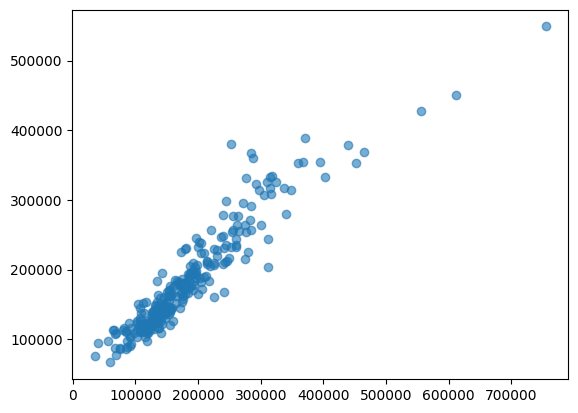

In [7]:
# 驗證模型
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

y_pred = model_1.predict(X)
r2 = r2_score(y, y_pred)
print("測試組 R2:", r2)
plt.scatter(y, y_pred, alpha=0.6)
plt.show()

# 實作 Gradio 介面

In [8]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.9 MB/s eta 0:00:00


In [11]:
import gradio as gr
import pandas as pd
import pickle
import numpy as np
import os

# 加載預處理器和模型
def load_preprocessor_and_model():
    # 請將這些路徑更改為您本地保存預處理器和模型的路徑
    preprocessor_path = '/content/drive/MyDrive/ML/preprocess.bin'
    model_path = '/content/drive/MyDrive/ML/model_1.bin'

    with open(preprocessor_path, "rb") as f:
        preprocessor = pickle.load(f)

    with open(model_path, "rb") as f:
        model = pickle.load(f)

    return preprocessor, model

# 創建預測函數
def predict_house_price(
    MSSubClass, MSZoning, LotFrontage, LotArea, Street,
    Alley, LotShape, LandContour, Utilities, LotConfig,
    LandSlope, Neighborhood, Condition1, Condition2, BldgType,
    HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd,
    RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType,
    MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual,
    BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1,
    BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating,
    HeatingQC, CentralAir, Electrical, FirstFlrSF, SecondFlrSF,
    LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath,
    HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual,
    TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType,
    GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual,
    GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF,
    EnclosedPorch, ThreeSsnPorch, ScreenPorch, PoolArea, PoolQC,
    Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType,
    SaleCondition
):
    # 建立輸入數據字典
    input_data = {
        'MSSubClass': MSSubClass,
        'MSZoning': MSZoning,
        'LotFrontage': LotFrontage,
        'LotArea': LotArea,
        'Street': Street,
        'Alley': Alley,
        'LotShape': LotShape,
        'LandContour': LandContour,
        'Utilities': Utilities,
        'LotConfig': LotConfig,
        'LandSlope': LandSlope,
        'Neighborhood': Neighborhood,
        'Condition1': Condition1,
        'Condition2': Condition2,
        'BldgType': BldgType,
        'HouseStyle': HouseStyle,
        'OverallQual': OverallQual,
        'OverallCond': OverallCond,
        'YearBuilt': YearBuilt,
        'YearRemodAdd': YearRemodAdd,
        'RoofStyle': RoofStyle,
        'RoofMatl': RoofMatl,
        'Exterior1st': Exterior1st,
        'Exterior2nd': Exterior2nd,
        'MasVnrType': MasVnrType,
        'MasVnrArea': MasVnrArea,
        'ExterQual': ExterQual,
        'ExterCond': ExterCond,
        'Foundation': Foundation,
        'BsmtQual': BsmtQual,
        'BsmtCond': BsmtCond,
        'BsmtExposure': BsmtExposure,
        'BsmtFinType1': BsmtFinType1,
        'BsmtFinSF1': BsmtFinSF1,
        'BsmtFinType2': BsmtFinType2,
        'BsmtFinSF2': BsmtFinSF2,
        'BsmtUnfSF': BsmtUnfSF,
        'TotalBsmtSF': TotalBsmtSF,
        'Heating': Heating,
        'HeatingQC': HeatingQC,
        'CentralAir': CentralAir,
        'Electrical': Electrical,
        '1stFlrSF': FirstFlrSF,
        '2ndFlrSF': SecondFlrSF,
        'LowQualFinSF': LowQualFinSF,
        'GrLivArea': GrLivArea,
        'BsmtFullBath': BsmtFullBath,
        'BsmtHalfBath': BsmtHalfBath,
        'FullBath': FullBath,
        'HalfBath': HalfBath,
        'BedroomAbvGr': BedroomAbvGr,
        'KitchenAbvGr': KitchenAbvGr,
        'KitchenQual': KitchenQual,
        'TotRmsAbvGrd': TotRmsAbvGrd,
        'Functional': Functional,
        'Fireplaces': Fireplaces,
        'FireplaceQu': FireplaceQu,
        'GarageType': GarageType,
        'GarageYrBlt': GarageYrBlt,
        'GarageFinish': GarageFinish,
        'GarageCars': GarageCars,
        'GarageArea': GarageArea,
        'GarageQual': GarageQual,
        'GarageCond': GarageCond,
        'PavedDrive': PavedDrive,
        'WoodDeckSF': WoodDeckSF,
        'OpenPorchSF': OpenPorchSF,
        'EnclosedPorch': EnclosedPorch,
        '3SsnPorch': ThreeSsnPorch,
        'ScreenPorch': ScreenPorch,
        'PoolArea': PoolArea,
        'PoolQC': PoolQC,
        'Fence': Fence,
        'MiscFeature': MiscFeature,
        'MiscVal': MiscVal,
        'MoSold': MoSold,
        'YrSold': YrSold,
        'SaleType': SaleType,
        'SaleCondition': SaleCondition
    }

    try:
        # 載入預處理器和模型
        preprocessor, model = load_preprocessor_and_model()

        # 使用預處理器轉換輸入數據
        processed_data = preprocessor.transform(input_data)

        # 進行預測
        prediction = model.predict(processed_data)[0]

        return f"預測房價: ${prediction:,.2f}"

    except Exception as e:
        return f"預測過程中發生錯誤: {str(e)}"

# 載入 field_value.bin 檔案以取得輸入選項的下拉選單值
with open("/content/drive/MyDrive/ML/field_value.bin", "rb") as f:
    field_value = pickle.load(f)

# 定義欄位的下拉選單列表
mssubclass_options = field_value['MSSubClass']
mszoning_options = field_value['MSZoning']
street_options = field_value['Street']
alley_options = field_value['Alley']
lotshape_options = field_value['LotShape']
landcontour_options = field_value['LandContour']
utilities_options = field_value['Utilities']
lotconfig_options = field_value['LotConfig']
landslope_options = field_value['LandSlope']
neighborhood_options = field_value['Neighborhood']
condition1_options = field_value['Condition1']
condition2_options = field_value['Condition2']
bldgtype_options = field_value['BldgType']
housestyle_options = field_value['HouseStyle']
roofstyle_options = field_value['RoofStyle']
roofmatl_options = field_value['RoofMatl']
exterior1st_options = field_value['Exterior1st']
exterior2nd_options = field_value['Exterior2nd']
masvnrtype_options = field_value['MasVnrType']
exterqual_options = field_value['ExterQual']
extercond_options = field_value['ExterCond']
foundation_options = field_value['Foundation']
bsmtqual_options = field_value['BsmtQual']
bsmtcond_options = field_value['BsmtCond']
bsmtexposure_options = field_value['BsmtExposure']
bsmtfintype1_options = field_value['BsmtFinType1']
bsmtfintype2_options = field_value['BsmtFinType2']
heating_options = field_value['Heating']
heatingqc_options = field_value['HeatingQC']
centralair_options = field_value['CentralAir']
electrical_options = field_value['Electrical']
kitchenqual_options = field_value['KitchenQual']
functional_options = field_value['Functional']
fireplacequ_options = field_value['FireplaceQu']
garagetype_options = field_value['GarageType']
garagefinish_options = field_value['GarageFinish']
garagequal_options = field_value['GarageQual']
garagecond_options = field_value['GarageCond']
paveddrive_options = field_value['PavedDrive']
poolqc_options = field_value['PoolQC']
fence_options = field_value['Fence']
miscfeature_options = field_value['MiscFeature']
sale_options = field_value['SaleType']
sale_condition_options = field_value['SaleCondition']


# 建立Gradio界面
def create_interface():
    with gr.Blocks(title="房價預測系統") as app:
        gr.Markdown("# 房價預測系統")
        gr.Markdown("請輸入房屋特徵以獲得價格預測")

        with gr.Accordion("基本信息"):
            mssubclass = gr.Dropdown(label="MS SubClass (建築類別)", choices=mssubclass_options.tolist(), value=60)
            mszoning = gr.Dropdown(label="MS Zoning (分區分類)", choices=mszoning_options.tolist(), value="RL")
            lotfrontage = gr.Number(label="Lot Frontage (距離街道的距離，英尺)", value=65)
            lotarea = gr.Number(label="Lot Area (地塊面積，平方英尺)", value=8450)
            street = gr.Dropdown(label="Street (街道類型)", choices=street_options.tolist(), value="Pave")
            alley = gr.Dropdown(label="Alley (巷道類型)", choices=alley_options.tolist(), value="Grvl")
            lotshape = gr.Dropdown(label="Lot Shape (地塊形狀)", choices=lotshape_options.tolist(), value="Reg")
            landcontour = gr.Dropdown(label="Land Contour (地形)", choices=landcontour_options.tolist(), value="Lvl")
            utilities = gr.Dropdown(label="Utilities (公用設施)", choices=utilities_options.tolist(), value="AllPub")
            lotconfig = gr.Dropdown(label="Lot Config (地塊配置)", choices=lotconfig_options.tolist(), value="Inside")

        with gr.Accordion("土地和建築特徵"):
            landslope = gr.Dropdown(label="Land Slope (坡度)", choices=landslope_options.tolist(), value="Gtl")
            neighborhood = gr.Dropdown(label="Neighborhood (社區名稱)", choices=neighborhood_options.tolist(), value="NAmes")
            condition1 = gr.Dropdown(label="Condition 1 (臨近主要街道或鐵路的情況)", choices=condition1_options.tolist(), value="Norm")
            condition2 = gr.Dropdown(label="Condition 2 (臨近主要街道或鐵路的情況(如有多種))", choices=condition2_options.tolist(), value="Norm")
            bldgtype = gr.Dropdown(label="Bldg Type (建築類型)", choices=bldgtype_options.tolist(), value="1Fam")
            housestyle = gr.Dropdown(label="House Style (住宅風格)", choices=housestyle_options.tolist(), value="1Story")
            overallqual = gr.Slider(label="Overall Qual (整體質量評分)", minimum=1, maximum=10, value=5)
            overallcond = gr.Slider(label="Overall Cond (整體條件評分)", minimum=1, maximum=10, value=5)
            yearbuilt = gr.Number(label="Year Built (建造年份)", value=1960)
            yearremodadd = gr.Number(label="Year Remod/Add (裝修年份)", value=1960)

        with gr.Accordion("屋頂和外觀"):
            roofstyle = gr.Dropdown(label="Roof Style (屋頂風格)", choices=roofstyle_options.tolist(), value="Gable")
            roofmatl = gr.Dropdown(label="Roof Matl (屋頂材料)", choices=roofmatl_options.tolist(), value="CompShg")
            exterior1st = gr.Dropdown(label="Exterior 1st (外牆材料)", choices=exterior1st_options.tolist(), value="VinylSd")
            exterior2nd = gr.Dropdown(label="Exterior 2nd (外牆材料(如有多種))", choices=exterior2nd_options.tolist(), value="VinylSd")
            masvnrtype = gr.Dropdown(label="Mas Vnr Type (石材外牆類型)", choices=masvnrtype_options.tolist(), value="BrkFace")
            masvnrarea = gr.Number(label="Mas Vnr Area (石材外牆面積)", value=0)
            exterqual = gr.Dropdown(label="Exter Qual (外觀質量)", choices=exterqual_options.tolist(), value="TA")
            extercond = gr.Dropdown(label="Exter Cond (外觀條件)", choices=extercond_options.tolist(), value="TA")
            foundation = gr.Dropdown(label="Foundation (基礎類型)", choices=foundation_options.tolist(), value="CBlock")

        with gr.Accordion("地下室"):
            bsmtqual = gr.Dropdown(label="Bsmt Qual (地下室質量)", choices=bsmtqual_options.tolist(), value="TA")
            bsmtcond = gr.Dropdown(label="Bsmt Cond (地下室條件)", choices=bsmtcond_options.tolist(), value="TA")
            bsmtexposure = gr.Dropdown(label="Bsmt Exposure (地下室暴露程度)", choices=bsmtexposure_options.tolist(), value="No")
            bsmtfintype1 = gr.Dropdown(label="Bsmt Fin Type 1 (地下室完成區類型)", choices=bsmtfintype1_options.tolist(), value="Rec")
            bsmtfintype2 = gr.Dropdown(label="Bsmt Fin Type 2 (第二個地下室完成區類型)", choices=bsmtfintype2_options.tolist(), value="Unf")
            bsmtfinsf1 = gr.Number(label="Bsmt Fin SF 1 (地下室完成區面積)", value=384)
            bsmtfinsf2 = gr.Number(label="Bsmt Fin SF 2 (第二個地下室完成區面積)", value=0)
            bsmtunfsf = gr.Number(label="Bsmt Unf SF (地下室未完成區面積)", value=500)
            totalbsmtsf = gr.Number(label="Total Bsmt SF (地下室總面積)", value=884)

        with gr.Accordion("供暖和制冷"):
            heating = gr.Dropdown(label="Heating (供暖類型)", choices=heating_options.tolist(), value="GasA")
            heatingqc = gr.Dropdown(label="Heating QC (供暖質量和條件)", choices=heatingqc_options.tolist(), value="TA")
            centralair = gr.Dropdown(label="Central Air (中央空調)", choices=centralair_options.tolist(), value="Y")
            electrical = gr.Dropdown(label="Electrical (電氣系統)", choices=electrical_options.tolist(), value="SBrkr")

        with gr.Accordion("面積和房間"):
            firstflrsf = gr.Number(label="1st Flr SF (一樓面積)", value=896)
            secondflrsf = gr.Number(label="2nd Flr SF (二樓面積)", value=0)
            lowqualfinsf = gr.Number(label="Low Qual Fin SF (低質量完成區面積)", value=0)
            grlivarea = gr.Number(label="Gr Liv Area (地上生活區面積)", value=896)
            bsmtfullbath = gr.Number(label="Bsmt Full Bath (地下室全衛數量)", value=0)
            bsmthalfbath = gr.Number(label="Bsmt Half Bath (地下室半衛數量)", value=0)
            fullbath = gr.Number(label="Full Bath (全衛數量)", value=1)
            halfbath = gr.Number(label="Half Bath (半衛數量)", value=0)
            bedroomabvgr = gr.Number(label="Bedroom AbvGr (地上臥室數量)", value=2)
            kitchenabvgr = gr.Number(label="Kitchen AbvGr (地上廚房數量)", value=1)
            kitchenqual = gr.Dropdown(label="Kitchen Qual (廚房質量)", choices=kitchenqual_options.tolist(), value="TA")
            totrmsabvgrd = gr.Number(label="TotRmsAbvGrd (地上房間總數(不含衛生間))", value=5)
            functional = gr.Dropdown(label="Functional (功能評級)", choices=functional_options.tolist(), value="Typ")

        with gr.Accordion("壁爐和車庫"):
            fireplaces = gr.Number(label="Fireplaces (壁爐數量)", value=0)
            fireplacequal = gr.Dropdown(label="Fireplace Qu (壁爐質量)", choices=fireplacequ_options.tolist(), value="Gd")
            garagetype = gr.Dropdown(label="Garage Type (車庫類型)", choices=garagetype_options.tolist(), value="Attchd")
            garageyrblt = gr.Number(label="Garage Yr Blt (車庫建造年份)", value=1960)
            garagefinish = gr.Dropdown(label="Garage Finish (車庫內部完成度)", choices=garagefinish_options.tolist(), value="Unf")
            garagecars = gr.Number(label="Garage Cars (車庫容納車數)", value=1)
            garagearea = gr.Number(label="Garage Area (車庫面積)", value=240)
            garagequal = gr.Dropdown(label="Garage Qual (車庫質量)", choices=garagequal_options.tolist(), value="TA")
            garagecond = gr.Dropdown(label="Garage Cond (車庫條件)", choices=garagecond_options.tolist(), value="TA")
            paveddrive = gr.Dropdown(label="Paved Drive (鋪砌車道)", choices=paveddrive_options.tolist(), value="Y")

        with gr.Accordion("戶外和其他特徵"):
            wooddecksf = gr.Number(label="Wood Deck SF (木甲板面積)", value=0)
            openporchsf = gr.Number(label="Open Porch SF (開放式門廊面積)", value=36)
            enclosedporch = gr.Number(label="Enclosed Porch (封閉式門廊面積)", value=0)
            threeseasonporch = gr.Number(label="3Ssn Porch (三季門廊面積)", value=0)
            screenporch = gr.Number(label="Screen Porch (紗窗門廊面積)", value=0)
            poolarea = gr.Number(label="Pool Area (游泳池面積)", value=0)
            poolqc = gr.Dropdown(label="Pool QC (游泳池質量)", choices=poolqc_options.tolist(), value="Fa")
            fence = gr.Dropdown(label="Fence (圍欄質量)", choices=fence_options.tolist(), value="MnPrv")
            miscfeature = gr.Dropdown(label="Misc Feature (其他未在其他類別中提及的特徵)", choices=miscfeature_options.tolist(), value="Shed")
            miscval = gr.Number(label="Misc Val (其他特徵的金錢價值)", value=0)
            mosold = gr.Number(label="Mo Sold (售出月份)", value=6)
            yrsold = gr.Number(label="Yr Sold (售出年份)", value=2010)
            saletype = gr.Dropdown(label="Sale Type (銷售類型)", choices=sale_options.tolist(), value="WD")
            salecondition = gr.Dropdown(label="Sale Condition (銷售條件)",choices=sale_condition_options.tolist(), value="Normal")

        predict_btn = gr.Button("預測房價")
        prediction = gr.Textbox(label="預測結果")

        predict_btn.click(
            fn=predict_house_price,
            inputs=[
                mssubclass, mszoning, lotfrontage, lotarea, street,
                alley, lotshape, landcontour, utilities, lotconfig,
                landslope, neighborhood, condition1, condition2, bldgtype,
                housestyle, overallqual, overallcond, yearbuilt, yearremodadd,
                roofstyle, roofmatl, exterior1st, exterior2nd, masvnrtype,
                masvnrarea, exterqual, extercond, foundation, bsmtqual,
                bsmtcond, bsmtexposure, bsmtfintype1, bsmtfinsf1,
                bsmtfintype2, bsmtfinsf2, bsmtunfsf, totalbsmtsf, heating,
                heatingqc, centralair, electrical, firstflrsf, secondflrsf,
                lowqualfinsf, grlivarea, bsmtfullbath, bsmthalfbath, fullbath,
                halfbath, bedroomabvgr, kitchenabvgr, kitchenqual,
                totrmsabvgrd, functional, fireplaces, fireplacequal, garagetype,
                garageyrblt, garagefinish, garagecars, garagearea, garagequal,
                garagecond, paveddrive, wooddecksf, openporchsf,
                enclosedporch, threeseasonporch, screenporch, poolarea, poolqc,
                fence, miscfeature, miscval, mosold, yrsold, saletype,
                salecondition
            ],
            outputs=prediction
        )

    return app

# 主函數
def main():
    app = create_interface()
    app.launch(share=True)

if __name__ == "__main__":
    main()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bd1d95b43d5d644ac1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
